# ME133b Set \#5

## Kevin Gauld



# Problem 1: Grid-Based Localization

### Imports + Setup

In [1]:
import numpy as np

from hw5_utilities import Visualization, Robot

#  Define the Walls
w = ['xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx',
     'x               x               x               x',
     'x                x             x                x',
     'x                 x           x                 x',
     'x        xxxx      x         x                  x',
     'x        x   x      x       x                   x',
     'x        x    x      x     x      xxxxx         x',
     'x        x     x      x   x     xxx   xxx       x',
     'x        x      x      x x     xx       xx      x',
     'x        x       x      x      x         x      x',
     'x        x        x           xx         xx     x',
     'x        x        x           x           x     x',
     'x        x        x           x           x     x',
     'x        x        x           x           x     x',
     'x                 xx         xx           x     x',
     'x                  x         x                  x',
     'x                  xx       xx                  x',
     'x                   xxx   xxx                   x',
     'x                     xxxxx         x           x',
     'x                                   x          xx',
     'x                                   x         xxx',
     'x            x                      x        xxxx',
     'x           xxx                     x       xxxxx',
     'x          xxxxx                    x      xxxxxx',
     'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx']

walls = np.array([[1.0*(c == 'x') for c in s] for s in w])
rows  = np.size(walls, axis=0)
cols  = np.size(walls, axis=1)

# ----- Helper Functions ------

# Normalizes a grid of probabilistic locations (sum of all locations = 1)
def normalize(grid):
    s = np.sum(grid)
    if (s == 0.0):
        print("LOST ALL BELIEF.  SHOULD NOT HAPPEN.  STARTING OVER!!!!")
        grid = 1.0 - walls
        s    = np.sum(grid)
    return grid/s

# Get the parameters for any given part a-e of the question. Given in a tuple formatted
# (visual, robot, probCmd, probProximal)
def get_init(part):
    # Initialize the figure.
    visual = Visualization(walls)
    
    # "for fun" case
    robot = robot = Robot(walls, probCmd = 0.8, probProximal = [0.9, 0.6, 0.3])
    if part == 'a':
        robot = Robot(walls)
    elif part == 'b':
        robot = Robot(walls, row=12, col=26)
    elif part == 'c':
        robot = Robot(walls, row=12, col=26, probProximal = [0.9, 0.6, 0.3])
    elif part == 'd' or part == 'e':
        robot = Robot(walls, row=15, col=47, 
                      probCmd = 0.8, probProximal = [0.9, 0.6, 0.3])



    # Pick the algorithm assumptions:
    probCmd      = 1.0   # Part (a/b), (c), (d)
    if part == 'e':
        probCmd = 0.8    # Part (e)
    
    
    probProximal = [0.9, 0.6, 0.3]      # Part (c), (d), (e)
    if part == 'a' or part == 'b':
        probProximal = [1.0]                # Part (a/b)
        
    
    return (visual, robot, probCmd, probProximal)

## a) Basic Code


### a1) Prediction code

Predicts a new state based on the current belief `bel`, direction given by `drow` and `dcol`, and chance of randomness `probCmd` (by default `1.0`). This will return a grid of states which is normalized such that the sum of the probabilities across the grid is `1.0`

In [2]:
def computePrediction(bel, drow, dcol, probCmd = 1):
    # Prepare an empty prediction grid.
    prd = np.zeros((rows,cols))

    # Iterate over/determine the probability for all (non-wall) elements.
    for row in range(1, rows-1):
        for col in range(1, cols-1):
            ncoord = (row+drow, col+dcol)
            ccoord = (row, col)
            # If the new position is not a wall, find probability of moving 
            # there, else do not change it (can't move into wall)
            prd[ncoord] += probCmd*bel[ccoord] if walls[ncoord] != 1 else 0
            
            # If the new position is a wall, then the probability of moving into the current
            # position is heightened, else lower by the probability of moving to the open position
            prd[ccoord] += (1-probCmd)*bel[ccoord] if walls[ncoord] != 1 else bel[ccoord]
            
    # Return the normalized prediction grid
    return normalize(prd)

### a2) Updating Belief

Based on the prior belief `prior`, the probability that the sensor is on `probSensor`, and the value of the sensor `sensor`, returns the new set of beliefs for the grid.

In [3]:
def updateBelief(prior, probSensor, sensor):
    # If the sensor is on, then the next value is prior * P(sensor is on)
    # if it's off, then the value is prior * (1 - P(sensor is on))
    post = probSensor*prior if sensor else prior*(1-probSensor)

    # Normalize.
    return normalize(post)

### a3) Precompute the Sensor Probability Grid

Given a direction `drow, dcol`, and a list of probabilities `probProximal` that the sensor triggers at dist=(index+1), returns the probability that the sensor is on at any given location on the grid.

In [4]:
def computeSensorProbability(drow, dcol, probProximal = [1.0]):
    # Prepare an empty probability grid.
    prob = np.zeros((rows, cols))

    # Pre-compute the probability for each grid element, knowing the
    # walls and the direction of the sensor.
    for row in range(1, rows-1):
        for col in range(1, cols-1):
            if walls[row][col] == 1: continue
            for i in range(len(probProximal)):
                crow = drow*(i+1)+row
                ccol = dcol*(i+1)+col
                if not 0<=crow<rows or not 0<=ccol<cols:
                    break
                if walls[crow][ccol] == 1:
                    prob[row][col] = probProximal[i]
                    break
    
    # Return the computed grid. Not normalized since the sensor can have
    # a 100% chance of being on for 2 points in the grid at the same time
    return prob

### Other utilities to run the motion

In [5]:
# Runs the grid for a given part from the user input
def run_grid(part):
    (visual, robot, probCmd, probProximal) = get_init(part)
    
    # Pre-compute probability grids for each sensor reading
    probUp    = computeSensorProbability(-1,  0, probProximal)
    probRight = computeSensorProbability( 0,  1, probProximal)
    probDown  = computeSensorProbability( 1,  0, probProximal)
    probLeft  = computeSensorProbability( 0, -1, probProximal)

    # Start with a uniform belief grid.
    bel = 1.0 - walls
    bel = (1/np.sum(bel)) * bel


    # Loop continually.
    while True:
        # Show the current belief.  Also show the actual position.
        visual.Show(bel, robot.Position())

        # Get the command key to determine the direction.
        while True:
            key = input("Cmd (q=quit, i=up, m=down, j=left, k=right) ?")
            if   (key == 'q'):  return
            elif (key == 'i'):  (drow, dcol) = (-1,  0) ; break
            elif (key == 'm'):  (drow, dcol) = ( 1,  0) ; break
            elif (key == 'j'):  (drow, dcol) = ( 0, -1) ; break
            elif (key == 'k'):  (drow, dcol) = ( 0,  1) ; break

        # Move the robot in the simulation.
        robot.Command(drow, dcol)
        
        # Compute a prediction.
        prd = computePrediction(bel, drow, dcol, probCmd)


        # Correct the prediction/execute the measurement update.
        bel = prd
        bel = updateBelief(bel, probUp,    robot.Sensor(-1,  0))
        bel = updateBelief(bel, probRight, robot.Sensor( 0,  1))
        bel = updateBelief(bel, probDown,  robot.Sensor( 1,  0))
        bel = updateBelief(bel, probLeft,  robot.Sensor( 0, -1))
        

# Shows the last position after a given list of commands for a given part
def get_final(part, cmdlist):
    (visual, robot, probCmd, probProximal) = get_init(part)

    # Pre-compute the probability grids for each sensor reading.
    probUp    = computeSensorProbability(-1,  0, probProximal)
    probRight = computeSensorProbability( 0,  1, probProximal)
    probDown  = computeSensorProbability( 1,  0, probProximal)
    probLeft  = computeSensorProbability( 0, -1, probProximal)

    # Start with a uniform belief grid.
    bel = 1.0 - walls
    bel = (1/np.sum(bel)) * bel

    for k in range(len(cmdlist)):
        (drow, dcol) = cmdlist[k]

        # Move the robot in the simulation.
        robot.Command(drow, dcol)

        # Compute a prediction.
        prd = computePrediction(bel, drow, dcol, probCmd)


        # Correct the prediction/execute the measurement update.
        bel = prd
        bel = updateBelief(bel, probUp,    robot.Sensor(-1,  0))
        bel = updateBelief(bel, probRight, robot.Sensor( 0,  1))
        bel = updateBelief(bel, probDown,  robot.Sensor( 1,  0))
        bel = updateBelief(bel, probLeft,  robot.Sensor( 0, -1))

    visual.Show(bel, robot.Position())
    print("Showing Final Position")

## a) Probability maps for up and right

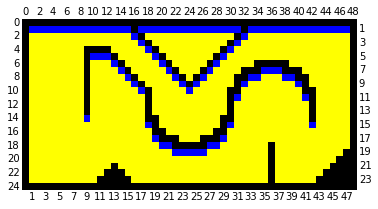

Showing sensor up


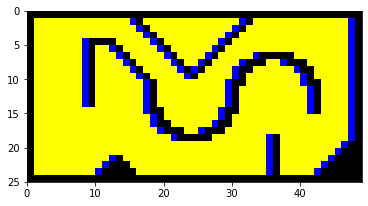

Showing sensor right


In [6]:
(visual, robot, probCmd, probProximal) = get_init('a')

probUp    = computeSensorProbability(-1,  0, probProximal)
probRight = computeSensorProbability( 0,  1, probProximal)

visual.Show(probUp)
print("Showing sensor up")
visual.Show(probRight)
print("Showing sensor right")

## b) Demoing the basic code

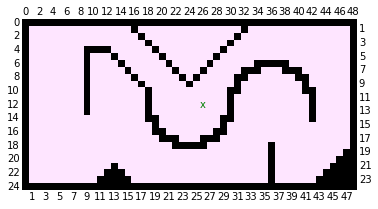

Cmd (q=quit, i=up, m=down, j=left, k=right) ?i


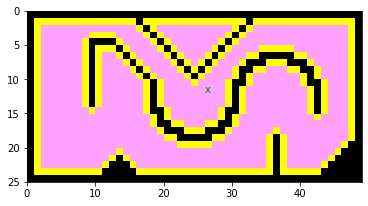

Cmd (q=quit, i=up, m=down, j=left, k=right) ?i


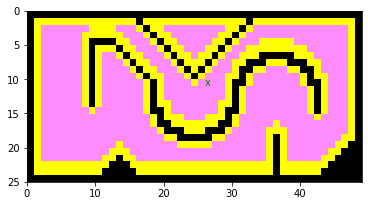

Cmd (q=quit, i=up, m=down, j=left, k=right) ?i


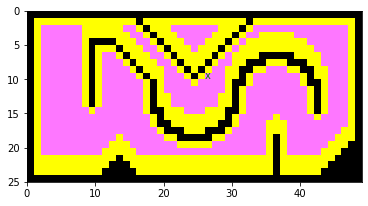

Cmd (q=quit, i=up, m=down, j=left, k=right) ?q


In [7]:
run_grid('b')

The minimum number of additional moves required is 4. The first move should be to the left, localizing to the wall. Moving down then left twice eliminates all possibilities other than the actual position of the robot.

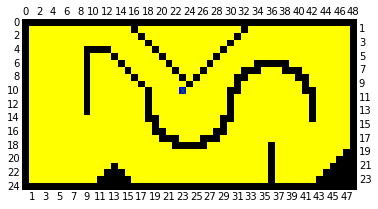

Showing Final Position


In [16]:
# Create a path of 3 up then 1 left then 1 down then 2 left then show it 
path = [(-1, 0), (-1,0), (-1,  0), 
        ( 0,-1), ( 1,0), ( 0, -1), (0, -1)]

get_final('b', path)

## c) Sensor extended range and noise

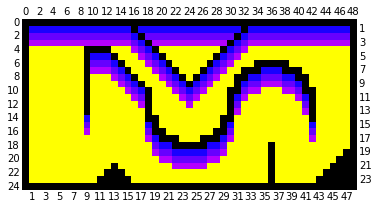

Showing sensor up


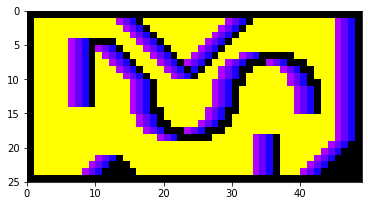

Showing sensor right


In [9]:
(visual, robot, probCmd, probProximal) = get_init('c')

probUp    = computeSensorProbability(-1,  0, probProximal)
probRight = computeSensorProbability( 0,  1, probProximal)


visual.Show(probUp)
print("Showing sensor up")
visual.Show(probRight)
print("Showing sensor right")

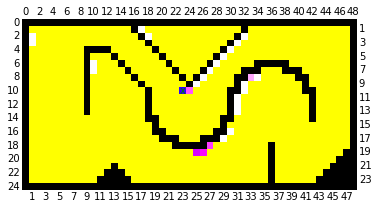

Showing Final Position


In [17]:
# Create a path of 3 up then 1 left then 1 down then 2 left then show it 
path = [(-1, 0), (-1,0), (-1,  0), 
        ( 0,-1), ( 1,0), ( 0, -1), (0, -1)]

get_final('c', path)

The move sequence does not converge to a single point because there is uncertainty in the distance of the detector from the wall. The noise within the system prevents the algorithm from making a certain guess as to where the robot is, even when it is touching the wall, because the sensor could just be detecting the wall from further away (although this is by design less likely)

## d) Adding Randomness to the Command Execution

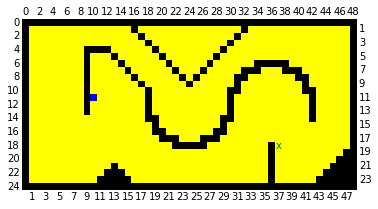

Showing Final Position


In [15]:
path = []
for k in range(18):
    if k < 12: path.append((0, -1))
    else: path.append((1, 0))
get_final('d', path)

## e) Fixing the Command Randomness

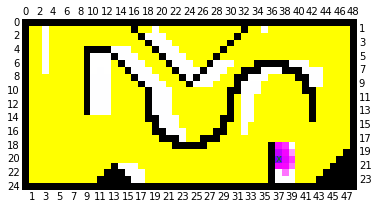

Showing Final Position


In [12]:
path = []
for k in range(18):
    if k < 12: path.append((0, -1))
    else: path.append((1, 0))
get_final('e', path)

# Problem 2: Time Spent

3 hours